##### TQ vs (PiT)Q

In [ ]:
import numpy as np
import time

S, A, K = 1000, 4, 50

R = np.random.random(size=(S, A))
T = np.random.random(size=(A, S, S))
omega = np.random.random(size=(K, S))
phi = np.random.random(size=(S, K))
T_ = omega @ T @ phi
R_ = omega @ R

discount = 0.9/S**3

q_value = np.zeros((S, A))
contracted_q_value = np.zeros((K, A))

def bellman_q(q_value: np.ndarray):
    return R + (discount * T @ q_value.max(axis=1)).T

def pi_bellman_q(contracted_q_value: np.ndarray):
    return R_ + (discount * T_ @ contracted_q_value.max(axis=1)).T

n_step = 1000

start_time = time.time()

for _ in range(n_step):
    q_value = bellman_q(q_value)

print("Time exact Bellman : {}".format(time.time() - start_time))

start_time = time.time()

for _ in range(n_step):
    contracted_q_value = pi_bellman_q(contracted_q_value)

print("Time projected Bellman : {}".format(time.time() - start_time))

##### V <-- Pi (R + TV) converge ?

In [ ]:
import numpy as np
from models.rooms_total import Model
from utils.calculus import get_full_phi_from_states_in_regions, get_weight_matrix_from_states_in_regions
from utils.calculus_projected import create_random_partition
from utils.calculus import get_optimal_policy, bellman_no_max

model = Model()
model.create_model()
# model._normalize_reward_matrix()
policy = get_optimal_policy(model, 'discounted', .9)
model.model_to_numpy()
K = int(model.state_dim * 0.9)
states_in_regions = create_random_partition(model, K)
phi = get_full_phi_from_states_in_regions(model, states_in_regions)[:, :K]
omega = get_weight_matrix_from_states_in_regions(model.state_dim, states_in_regions, K)
V = np.zeros((model.state_dim))

# policy = np.random.randint(low=0, high=model.action_dim, size=model.state_dim)


t_pi = np.zeros((model.state_dim, model.state_dim))
r_pi = np.zeros((model.state_dim))
for state in range(model.state_dim):
    action = policy[state]
    t_pi[state] = model.transition_matrix[action][state]
    r_pi[state] = model.reward_matrix[state, action]

value = np.zeros((model.state_dim)) +2 

def projected_bellman(value : np.ndarray):
    return phi @ omega @ (r_pi + t_pi @ value)

for _ in range(1000):
    value = projected_bellman(value)
    # print(np.linalg.norm(value - projected_bellman(value)))

print(np.round(value.reshape((10, 10)), 2))

print('Conclusion : Projected Bellman Operator does not converge for the total criterion.')
print("Conclusion alternative : ça pourrait converger.")

##### V <-- (min_S_k (R + TV))_k converge ?

In [ ]:
import numpy as np
from models.rooms_total import Model
from utils.calculus import get_full_phi_from_states_in_regions, get_weight_matrix_from_states_in_regions
from utils.calculus_projected import create_random_partition
from utils.calculus import get_optimal_policy, bellman_no_max

model = Model()
model.create_model()
# model._normalize_reward_matrix()
policy = get_optimal_policy(model, 'discounted', .9)
model.model_to_numpy()
K = int(model.state_dim * 0.9)
states_in_regions = create_random_partition(model, K)
phi = get_full_phi_from_states_in_regions(model, states_in_regions)[:, :K]
omega = get_weight_matrix_from_states_in_regions(model.state_dim, states_in_regions, K)
V = np.zeros((model.state_dim))

# policy = np.random.randint(low=0, high=model.action_dim, size=model.state_dim)


t_pi = np.zeros((model.state_dim, model.state_dim))
r_pi = np.zeros((model.state_dim))
for state in range(model.state_dim):
    action = policy[state]
    t_pi[state] = model.transition_matrix[action][state]
    r_pi[state] = model.reward_matrix[state, action]

value = np.zeros((model.state_dim))+2

def projected_bellman(value : np.ndarray):
    value = r_pi + t_pi @ value
    return phi @ np.array([[np.min(value[states_in_regions[k]]) for k in range(K)]]).reshape((K, 1))

for _ in range(1000):
    value = projected_bellman(value)
    # print(np.linalg.norm(value - projected_bellman(value)))

# print(np.round(value.reshape((10, 10)), 2))

print("On a l'impression que oui mais en fait non.")

#### Pi T V sparse vs TV sparse

In [ ]:
import numpy as np
from models.rooms_total import Model
from utils.calculus import get_full_phi_from_states_in_regions, get_weight_matrix_from_states_in_regions
from utils.calculus_projected import create_random_partition, projected_optimal_bellman_operator
from utils.calculus import get_optimal_policy, bellman_no_max, optimal_bellman_operator
from scipy.sparse import csr_matrix
import time

discount = 0.9
epsilon = 1e-2
n_step = 100000
aggregation_rate = 0.8

model = Model()
model.create_model()
K = int(model.state_dim * aggregation_rate)

states_in_regions = create_random_partition(model, K)

phi = get_full_phi_from_states_in_regions(model, states_in_regions)[:, :K]
omega = get_weight_matrix_from_states_in_regions(model.state_dim, states_in_regions, K)

agg_reward = model.reward_matrix

agg_transition = [transition.dot(phi) for transition in model.transition_matrix]

value = np.zeros((model.state_dim))

start_time = time.time()

for _ in range(n_step):
    value = optimal_bellman_operator(model, value, discount)

exact_time = time.time() - start_time

print("Exact steps time : {}".format(exact_time))


start_time = time.time()

contracted_value = np.zeros((K))

for _ in range(n_step):
    contracted_value = projected_optimal_bellman_operator(model, discount, contracted_value, agg_transition, agg_reward, omega)

agg_time = time.time() - start_time

print("Agg steps time : {}".format(agg_time))

print("Conclusion : les itérations agrégées restent bien meilleures de {} %.".format(np.round(1 - agg_time / exact_time, 2) * 100))

#### A quoi ressemble la distribution des temps de calcul ?

In [ ]:
import numpy as np
from models.rooms import Model
from utils.calculus import get_full_phi_from_states_in_regions, get_weight_matrix_from_states_in_regions
from utils.calculus_projected import create_random_partition, projected_optimal_bellman_operator
from utils.calculus import get_optimal_policy, bellman_no_max, optimal_bellman_operator
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt

discount = 0.9
n_sample = 100

model = Model()
model.create_model()

def sample():
    value = np.zeros((model.state_dim))
    start_time = time.time()
    for _ in range(100):
        value = optimal_bellman_operator(model, value, discount)

    return time.time() - start_time

time_sample = [sample() for _ in range(n_sample)]

print(np.mean(time_sample))
print(np.median(time_sample))

plt.hist(time_sample, bins='auto')
plt.show()

##### Exemple de MDP cas total

In [ ]:
from mdptoolbox.mdp import PolicyIteration
import numpy as np

T = np.array([[[0.8, 0.2], [1, 0.0]]])
R = np.array([[[0, 1], [0, 0]]])
vi = PolicyIteration(T, R, 1.)
vi.run()
vi.V

#### Faire varier les étapes de Bellman pour la désagrégation

In [ ]:
import numpy as np
from models.tandem import Model, param_list
from solvers.aggregated_vi import Solver
import matplotlib.pyplot as plt
from tqdm import trange
import time

model = Model(param_list[0])
model.create_model()
model._model_to_numpy()

discount = 0.8
epsilon = 1e-1
bellman_updates = 20

updates = trange(bellman_updates)
runtimes = []


for bellman_updates in updates:

    avi = Solver(model, discount, epsilon, False, bellman_updates)
    avi.run()
    runtimes.append(avi.runtime)

print("Conclusion : l'hyperparamètre n dépend beaucoup du modèle.")

plt.scatter(list(updates), runtimes)
plt.show()

#### Initialisation de Policy Iteration Modified

#### np.sum vs sum on scipy sparse arrays

In [ ]:
import numpy as np
import time
from scipy.sparse import csr_matrix

matrix = csr_matrix((np.random.random((1000, 1000)) < 0.5).astype(int))

def timeit(function, n_step = 10000):
    start_time = time.time()
    for _ in range(n_step):
        function()
    runtime = (time.time() - start_time)/n_step
    return runtime

def sum_numpy():
    return np.sum(matrix[0])

def sum_python():
    return sum(matrix[0])

def sum_scipy():
    return matrix[0].sum()

print(timeit(sum_numpy))
print(timeit(sum_python))
print(timeit(sum_scipy))

#### Pour Tandem, a quoi ressemble V^*-R.max() ?

In [ ]:
from models.tandem import Model, param_list
from utils.exact_value_function import get_exact_value
import matplotlib.pyplot as plt
from utils.calculus import norminf
import numpy as np

discount = 0.999
eps = 0.04

model = Model()
model.create_model()
optimal_value = get_exact_value(model, 'discounted', discount)
value = optimal_value - model.reward_matrix.max(axis=1)

def f(x):
    return norminf(optimal_value - model.reward_matrix.max(axis=1) * x)

values = np.linspace(204, 206, 1000)

plt.plot(values, [f(x) for x in values])
plt.show()

print(values[np.argmin([f(x) for x in values])])

#### Plot le temps de calcul de VI en fonction du discount, pareil pour PIM, PDVI, PDQVI, PDPIM

In [ ]:
from solvers.aggregated_vi import Solver as Avi
from solvers.aggregated_qvi import Solver as Aqvi
from solvers.aggregated_pim import Solver as Apim

from solvers.personal_vi import Solver as Vi
from solvers.personal_pim import Solver as Pim
from solvers.bertsekas_pi import Solver as Bert
from solvers.chen_td import Solver as Chen

from utils.generic_model import NUMPY, SPARSE

import numpy as np
from models.rooms import Model, param_list
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

level = 1
discounts = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999, 0.99995]
f = lambda x : np.log10(x) - np.log10(1-x)
discounts_plot = [f(discount) for discount in discounts]
epsilon = 1e-1
env = Model(param_list[level])
env.create_model(mode=SPARSE, check_transition=False)

print(env.state_dim)

solvers = [Avi, Aqvi, Apim, Vi, Pim]
results = {}

for discount_index in trange(len(discounts)):
    discount = discounts[discount_index]
    for Solver in solvers:
        solver = Solver(env, discount, epsilon)
        solver.run()
        try:
            results[solver.name].append(solver.runtime)
        except KeyError:
            results[solver.name] = [solver.runtime]

plt.yscale('log')

for (solver_name, runtimes) in results.items():
    plt.plot(discounts_plot, runtimes, label=solver_name)

plt.legend()
plt.show()

In [ ]:
from solvers.aggregated_vi import Solver as Avi
from solvers.aggregated_qvi import Solver as Aqvi
from solvers.aggregated_pim import Solver as Apim

from solvers.personal_vi import Solver as Vi
from solvers.personal_pim import Solver as Pim
from solvers.bertsekas_pi import Solver as Bert
from solvers.chen_td import Solver as Chen

from utils.generic_model import NUMPY, SPARSE

import numpy as np
from models.rooms import Model, param_list
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

level = 2
discounts = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.8, 0.85, 0.9, 0.95, 0.99, 0.995, 0.999, 0.9995, 0.9999, 0.99995]
f = lambda x : np.log(x) - np.log(1-x)
discounts_plot = [f(discount) for discount in discounts]
epsilon = 1e-1
env = Model(param_list[level])
env.create_model(mode=SPARSE, check_transition=False)

print(env.state_dim)

solvers = [Avi, Aqvi, Apim, Vi, Pim]
results = {}

for discount in tqdm(discounts):
    for Solver in solvers:
        solver = Solver(env, discount, epsilon)
        solver.run()
        try:
            results[solver.name].append(solver.runtime)
        except KeyError:
            results[solver.name] = [solver.runtime]

plt.yscale('log')

for (solver_name, runtimes) in results.items():
    plt.plot(discounts_plot, runtimes, label=solver_name)

plt.legend()
plt.show()

#### $Span V* <= \epsilon$ and $\tilde{V}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.tandem import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator
from utils.calculus import norminf, get_value_policy_value

discount = 0.99
epsilon = 0.2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False)
exact_value = get_exact_value(model, 'discounted', discount)

contracted_value = np.zeros((1))

partition = ValuePartition(model, discount, SPARSE)
contracted_value = partition.divide_regions_along_tv(exact_value, epsilon, contracted_value)
partition._build_full_phi()
partition._build_weights(True)
agg_tr, agg_r = partition._compute_aggregate_transition_reward()

contracted_value, _ = apply_pobo_until_var_small(model, discount, agg_tr, agg_r, partition.weights, 1e-3)
v_tilde = partition._partial_phi() @ contracted_value

print(distance_to_optimal(v_tilde, model, 'discounted', discount))

def compute_precision(epsilon):
    global model
    global discount

    contracted_value = np.zeros((1))

    partition = ValuePartition(model, discount, SPARSE)
    contracted_value = partition.divide_regions_along_tv(exact_value, epsilon, contracted_value)
    partition._build_full_phi()
    partition._build_weights(True)
    agg_tr, agg_r = partition._compute_aggregate_transition_reward()

    contracted_value, _ = apply_pobo_until_var_small(model, discount, agg_tr, agg_r, partition.weights, 1e-1, contracted_value, SPARSE)


    v_tilde = np.array(partition._partial_phi() @ contracted_value)
    error_to_optimal = distance_to_optimal(v_tilde, model, 'discounted', discount)
    partition_shrinkage = partition._number_of_regions()/model.state_dim
    v_pi_v = get_value_policy_value(model, discount, v_tilde, 1e-1, SPARSE)
    v_pi_v_v = distance_to_optimal(v_pi_v, model, 'discounted', discount)

    results = {
        'distance_to_optimal' : error_to_optimal,
        'v_tilde' : v_tilde,
        'partition_shrinkage' : partition_shrinkage,
        'v_pi_v_v' : v_pi_v_v,
    }

    return results

In [ ]:
X = 10**np.linspace(-6, 3, 15)

experiment = [compute_precision(eps) for eps in tqdm(X)]
v_v = [result['distance_to_optimal'] for result in experiment]
v_pi = [result['v_pi_v_v'] for result in experiment]

plt.plot(X, v_v/X, label='|Vt - V^*|')
plt.plot(X, v_pi/X, label='|Vpi - V^*|')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator
from utils.calculus import norminf, get_value_policy_value
from utils.partition_generic import GenericPartition

discount = 0.99
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False)
exact_value = get_exact_value(model, 'discounted', discount)

contracted_value = np.zeros((4))

partition = GenericPartition(model, discount, 'sparse')
region1 = []
for i in range(5):
    region1+=list(range(10*i, 10*i+5))
region2 = []
for i in range(5):
    region2+=list(range(5+10*i, 5+10*i+5))
region3 = []
for i in range(5):
    region3+=list(range(50+10*i, 50+10*i+5))
region4 = []
for i in range(5):
    region4+=list(range(55+10*i, 55+10*i+5))
partition.states_in_region = [region1, region2, region3, region4]
partition._compute_weights_phi()
partition.compute_agg_trans_reward_v();

import seaborn as sns
contracted_value = np.zeros((4))


for i in range(3):
    value = partition._partial_phi() @ contracted_value
    value = value.reshape((10, 10))
    sns.heatmap(value)
    plt.savefig('images/rooms_partition_{}'.format(i))
    plt.show()
    for _ in range(12):
        contracted_value = projected_optimal_bellman_operator(model, discount, contracted_value, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix, partition.weights)
    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator
from utils.partition_generic import GenericPartition

discount = 0.99
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False)
exact_value = get_exact_value(model, 'discounted', discount)

contracted_value = np.zeros((1))
partition = GenericPartition(model, discount, 'sparse')


import seaborn as sns

partition._compute_weights_phi()
partition.compute_agg_trans_reward_v()

for i in range(4):
    for _ in range(100):
        contracted_value = projected_optimal_bellman_operator(model, discount, contracted_value, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix, partition.weights)

    value = partition._partial_phi() @ contracted_value
    bellman_value = optimal_bellman_operator(model, value, discount)
    contracted_value = partition.divide_all_regions_along_value_update_contracted_value(bellman_value, 0.01, contracted_value)
    partition._compute_weights_phi()
    partition.compute_agg_trans_reward_v()

    value = partition._partial_phi() @ contracted_value
    value = value.reshape((10, 10))
    sns.heatmap(value)
    plt.savefig('images/rooms_pdvi_{}'.format(i))
    plt.show()

for i in range(200):
    for _ in range(100):
        contracted_value = projected_optimal_bellman_operator(model, discount, contracted_value, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix, partition.weights)

    value = partition._partial_phi() @ contracted_value
    bellman_value = optimal_bellman_operator(model, value, discount)
    contracted_value = partition.divide_all_regions_along_value_update_contracted_value(bellman_value, 0.01, contracted_value)
    partition._compute_weights_phi()
    partition.compute_agg_trans_reward_v()

value = partition._partial_phi() @ contracted_value
value = value.reshape((10, 10))
sns.heatmap(value)
plt.savefig('images/rooms_pdvi_4')
plt.show()

print(partition._number_of_regions())

#### Il se passe quoi si on dépasse V^* dans le cas total ?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

value = 0 * np.ones((model.state_dim))

for iter in range(80):
    value = optimal_bellman_operator(model, value, discount)
    if np.random.random() < 0.3:
        plt.plot(value, label='iter {}'.format(iter))

plt.plot(value-1)

plt.legend()
plt.show()

value = -100 * np.ones((model.state_dim))

for iter in range(100):
    value = optimal_bellman_operator(model, value, discount)
    if np.random.random() < 0.1:
        plt.plot(value, label='iter {}'.format(iter))

plt.plot(value-1)

plt.legend()
plt.show()

#### PDQVI cas total

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

partition = QValuePartition(model, discount, SPARSE)
contracted_q_value = 0 * np.ones((partition._number_of_regions(), model.action_dim))

partition._compute_aggregate_transition_reward()

for _ in range(20):
    partition._compute_weights_phi()
    partition.compute_agg_trans_reward_q()

    for _ in range(100):
        prev = contracted_q_value
        contracted_q_value = projected_optimal_q_bellman_operator(model, discount, prev, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix)
    
    q_value = partition._partial_phi().dot(contracted_q_value)
    sns.heatmap(q_value.max(axis=1).reshape((10, 10)))
    plt.show()

    bellman = q_optimal_bellman_operator(model, q_value, discount)

    for action in range(model.action_dim):
        contracted_q_value = partition.divide_all_regions_along_value_update_contracted_q_value(bellman[:, action], epsilon, contracted_q_value)
    # print(partition._number_of_regions())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

s1, s2 = 25, 75

for aa in range(model.action_dim):
    model.transition_matrix[aa][s1, :] = 0.
    model.transition_matrix[aa][s1, s1] = 1.

    model.transition_matrix[aa][s2, :] = 0.
    model.transition_matrix[aa][s2, s2] = 1.

for k in range(10):
    for l in range(5, 10):
        index = k*10+l
        model.reward_matrix[index, :] = 0.

model.reward_matrix[99, :] = -1.

partition = QValuePartition(model, discount, SPARSE)
contracted_q_value = 0 * np.ones((partition._number_of_regions(), model.action_dim))

partition._compute_aggregate_transition_reward()

for _ in range(20):
    partition._compute_weights_phi()
    partition.compute_agg_trans_reward_q()

    for _ in range(100):
        prev = contracted_q_value
        contracted_q_value = projected_optimal_q_bellman_operator(model, discount, prev, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix)
    
    q_value = partition._partial_phi().dot(contracted_q_value)
    sns.heatmap(q_value.max(axis=1).reshape((10, 10)))
    plt.show()

    bellman = q_optimal_bellman_operator(model, q_value, discount)

    for action in range(model.action_dim):
        contracted_q_value = partition.divide_all_regions_along_value_update_contracted_q_value(bellman[:, action], epsilon, contracted_q_value)
    # print(partition._number_of_regions())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

model.transition_matrix[0][12, 2] = 1.
model.transition_matrix[0][12, 12] = 0.

partition = QValuePartition(model, discount, SPARSE)

contracted_q_value = -15 * np.ones((partition._number_of_regions(), model.action_dim))

partition._compute_aggregate_transition_reward()

for _ in range(20):
    partition._compute_weights_phi()
    partition.compute_agg_trans_reward_q()

    for _ in range(100):
        prev = contracted_q_value
        contracted_q_value = projected_optimal_q_bellman_operator(model, discount, prev, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix)
    
    q_value = partition._partial_phi().dot(contracted_q_value)
    sns.heatmap(q_value.max(axis=1).reshape((10, 10)))
    plt.show()

    bellman = q_optimal_bellman_operator(model, q_value, discount)

    for action in range(model.action_dim):
        contracted_q_value = partition.divide_all_regions_along_value_update_contracted_q_value(bellman[:, action], epsilon, contracted_q_value)
    # print(partition._number_of_regions())



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

model.reward_matrix -= 1

value = np.zeros((model.state_dim))

for _ in range(4):
    value = optimal_bellman_operator(model, value, discount)
    plt.plot(value)
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from utils.generic_model import NUMPY, SPARSE
from models.rooms import Model, param_list
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns

discount = 1.
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)

# model.reward_matrix -= 1

value = np.zeros((model.state_dim))-100

for _ in range(10):
    value = optimal_bellman_operator(model, value, discount)
    plt.plot(value)
    plt.show()

#### Différents weights pour partition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list

discount = 0.999
epsilon = 1e-2
level = 1
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)

from solvers.aggregated_vi import Solver

solver = Solver(model, discount, epsilon)
solver.run(False)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.dam import Model, param_list

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)

from solvers.aggregated_vi import Solver

solver = Solver(model, discount, epsilon)
solver.run(False)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

#### Autres méthodes de partition

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)

from solvers.aggregated_vi import Solver

solver = Solver(model, discount, epsilon)
solver.run(False)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True)
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

solver = Solver(model, discount, epsilon)
solver.run(True, 'average_average_reward')
print(solver.runtime)
print(distance_to_optimal(solver.value, model, 'discounted', discount))

#### PC Policy Update

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.tandem import Model, param_list
from tqdm import trange

discount = 0.9
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=True)
model._model_to_numpy()


value = np.random.random(size=(model.state_dim))
for _ in range(1000):
    value = optimal_bellman_operator(model, value, discount)

res = []

for rn in trange(1, 440, 20):

    partition = GenericPartition(model, discount, SPARSE)
    partition.generate_random_partition(rn)
    partition._compute_weights_phi()

    q_value = model.reward_matrix + discount * (model.transition_matrix @ value).T
    contracted_q_value = partition.weights @ q_value
    contracted_policy = partition._partial_phi() @ contracted_q_value.argmax(axis=1)
    policy = q_value.argmax(axis=1)
    p_value = full_iterative_policy_evaluation(model, discount, policy, 1e-2, NUMPY)
    cp_value = full_iterative_policy_evaluation(model, discount, contracted_policy, 1e-2, NUMPY)

    res.append(np.abs(p_value-cp_value).mean()*(1-discount))

plt.plot(res)
plt.yscale('log')

### Pi^2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list
from tqdm import trange

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()


value = np.random.random(size=(model.state_dim))
for _ in range(1000):
    value = optimal_bellman_operator(model, value, discount)

policy = np.random.randint(model.action_dim, size=model.state_dim)
policy = np.argmax(bellman_no_max(model, value, discount), axis=1)
value_p = full_iterative_policy_evaluation(model, discount, policy, 1e-3)

tp, rp = compute_transition_reward_policy(model, policy)
tp2 = tp @ tp
rp2 = rp + discount * tp * rp

iterative_policy_evaluation(tp2, rp2, discount, 1e-3, NUMPY)

### TV exact et Pi T V

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model
from tqdm import trange

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(100, 4)
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

value = np.zeros((model.state_dim))

results = []

n = 20

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value))))

plt.plot(results)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list
from tqdm import trange

mode = SPARSE


discount = 0.9
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

partition = GenericPartition(model, discount, mode)

value = np.zeros((model.state_dim))

results = []

n = 20

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value))))

plt.plot(results)

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

partition = GenericPartition(model, discount, mode)

value = np.zeros((model.state_dim))

results = []

n = 20

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value))))

plt.plot(results)


plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.mountain import Model, param_list
from tqdm import trange

mode = SPARSE

partition = GenericPartition(model, discount, mode)

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

print(model.state_dim)

value = np.zeros((model.state_dim))

results = []

n = 20

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value))))

plt.plot(results)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list
from tqdm import trange

mode = SPARSE

discount = 0.99
epsilon = 1e-2
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

partition = GenericPartition(model, discount, mode)

print(model.state_dim)

value = np.zeros((model.state_dim))

results = []

n = 50

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value/epsilon).astype(int))))

plt.plot(results)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.tandem import Model, param_list
from tqdm import trange

mode = SPARSE

discount = 0.999
epsilon = 0.1
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

partition = GenericPartition(model, discount, mode)

print(model.state_dim)

value = np.zeros((model.state_dim))

results = []

n = 50

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value/epsilon).astype(int)))/model.state_dim)

plt.plot(results)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model, param_list
from tqdm import trange

mode = SPARSE

discount = 0.999
epsilon = 0.1
epsiprime = 0.001
level = 0
model = Model(param_list[level])
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

model.reward_matrix += epsiprime*np.random.random((model.state_dim, model.action_dim))

partition = GenericPartition(model, discount, mode)

print(model.state_dim)

value = np.zeros((model.state_dim))

results = []

n = 50

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value/epsilon).astype(int)))/model.state_dim)

plt.plot(results)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.taxi import Model
from tqdm import trange

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(100, 4)
model.create_model(mode=NUMPY, check_transition=False, normalize_reward=False)
model._model_to_numpy()

value = np.zeros((model.state_dim))

results = []

n = 20

for i in range(n):
    value = optimal_bellman_operator(model, value, discount)
    results.append(len(set((value))))

plt.plot(results)
plt.show()

# Bellman_update_variation

#### Value Iteration base

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns

from tqdm import trange
from solvers.personal_vi import Solver

from models.management import Model

discount = 0.999
epsilon = 1e-2
model = Model(5000, 32)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()


sol = Solver(model, discount, epsilon)
sol.run()
print(np.round(sol.runtime, 1))

#### bellmanupdate

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.garnet import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(1000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)
model._model_to_sparse()

sol = Solver(model, discount, 1e-2, bellman_updates=1)
sol.run()
print(np.round(sol.runtime, 1))

#### epsilon decreasing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.garnet import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(1000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)
model._model_to_sparse()

sol = Solver(model, discount, 1e-2, bellman_updates=1, decreasing_span_bound=False)
sol.run(max_agg_step=100)
print(np.round(sol.runtime, 1))


#### Max agg steps

In [ ]:
import dis
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
model = Model(5000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)
model._model_to_sparse()

sol = Solver(model, discount, 1e-2, bellman_updates=1)
sol.run(max_agg_step=100)
print(np.round(sol.runtime, 1))
print(optimal_bellman_residual(model, sol.value, discount))

#### Weighted

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.management import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
model = Model(5000, 32)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()

sol = Solver(model, discount, 1e-2, bellman_updates=1)

sol.run(with_norm_weights=True, norm_method='average_reward')
# sol.run()
print(np.round(sol.runtime, 1))
print(optimal_bellman_residual(model, sol.value, discount))

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.garnet import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
model = Model(1000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()

sol = Solver(model, discount, 1e-2, bellman_updates=1)

sol.run(with_norm_weights=True, norm_method='average_reward')
# sol.run()
print(np.round(sol.runtime, 1))
print(optimal_bellman_residual(model, sol.value, discount))

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns

from tqdm import trange
from solvers.aggregated_vi_options import Solver

from models.garnet import Model

discount = 0.999
epsilon = 1e-2
model = Model(1000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()


sol = Solver(model, discount, epsilon)
sol.run(with_norm_weights=True)
print(np.round(sol.runtime, 1))

#### Oil problem exploration

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.oil import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.9
epsilon = 1e-2
model = Model(200, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()

val = get_exact_value(model, 'discounted', discount)
plt.plot(val)
plt.show()

#### Ambulance problem exploration

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.ambulance import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.9
epsilon = 1e-2
model = Model(25, 4)
model.create_model(mode=SPARSE, check_transition=True, normalize_reward=True)
model._model_to_sparse()

val = get_exact_value(model, 'discounted', discount)
plt.plot(val)
plt.show()

#### Tiles

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns

from tqdm import trange
from solvers.aggregated_vi_tiles import Solver

from models.garnet import Model

discount = 0.999
epsilon = 1e-2
model = Model(1000, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()


sol = Solver(model, discount, epsilon, bellman_updates=1, n_tiles=15)
sol.run()
print(np.round(sol.runtime, 20))

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns

from tqdm import trange
from solvers.aggregated_vi_tiles import Solver

from models.management import Model

discount = 0.999
epsilon = 1e-2
model = Model(5000, 32)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()


sol = Solver(model, discount, epsilon, bellman_updates=1, n_tiles=rc)
sol.run()
print(np.round(sol.runtime, 20))

In [ ]:
import dis
from gurobipy import norm
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max, optimal_bellman_residual
from utils.partition_generic import GenericPartition
import seaborn as sns

from tqdm import trange
from solvers.personal_vi import Solver

from models.management import Model

discount = 0.999
epsilon = 1e-2
model = Model(5000, 32)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=True)
model._model_to_sparse()


sol = Solver(model, discount, epsilon)
sol.run()
print(np.round(sol.runtime, 1))
plt.plot(sol.value)

#### MDP equivalents ou pas ?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(100, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)
model._model_to_sparse()

sol = Solver(model, discount, epsilon)
sol.run()
sol.partition._number_of_regions()

policy = np.argmax(bellman_no_max(model, get_exact_value(model, 'discounted', discount), discount), axis=1)
value = np.random.randint(2, size=model.state_dim)

phi = sol.partition._partial_phi()
omega = sol.partition.weights
averaging_matrix = phi.dot(omega)

full_state_transition = [averaging_matrix.dot(transition.dot(averaging_matrix)) for transition in model.transition_matrix]
full_state_reward = averaging_matrix.dot(model.reward_matrix)

from utils.generic_model import CustomModel

averaged_model = CustomModel(full_state_transition, full_state_reward, 'custom')

from utils.calculus import bellman_policy_operator

transition_full_policy, reward_full_policy = compute_transition_reward_policy(averaged_model, policy)
bellman_policy_operator(value, discount, transition_full_policy, reward_full_policy)

transition_policy, reward_policy = compute_transition_reward_policy(model, policy)
bellman_policy_operator(value, discount, transition_policy, reward_policy)

### Spectrum transition matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    plt.scatter(eigenvalues.real, eigenvalues.imag, color='blue', marker='o')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.title('Spectrum of the Matrix')
    plt.show()

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.generic_model import NUMPY, SPARSE
from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.partition_q_value import QValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator, projected_optimal_q_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator, q_optimal_bellman_operator, iterative_policy_evaluation, compute_transition_reward_policy, full_iterative_policy_evaluation, bellman_no_max
from utils.partition_generic import GenericPartition
import seaborn as sns
from models.rooms import Model
from tqdm import trange
from solvers.aggregated_vi import Solver

discount = 0.999
epsilon = 1e-2
level = 0
model = Model(100, 4)
model.create_model(mode=SPARSE, check_transition=False, normalize_reward=False)
model._model_to_numpy()

P = model.transition_matrix[0]
R = model.reward_matrix[:, 0]

plot_spectrum(P)

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

# data
x = [4900, 10000, 49284, 99856, 250000, 1000000]
y1 = [91.6, 173.6, 1167.7, 3419.5, 15858.2, 219789.2]
y2 = [10.1, 11.1, 28.6, 61.9, 207.4, 2274.4]
y3 = [77.6, 257.6, 8727.4, 46546.7, 437824.1, np.nan]
y4 = [56.3, 111.2, 565.1, 2801.6, 4111.8, np.nan]
y5 = [364.5, 987.0, 19748.5, 92574.3, 728272.9, np.nan]
y6 = [1489.2, 2154.8, 5021.9, 7661.8, 14057.0, np.nan]
y7 = [599.0, np.nan, 27137.2, 116716.5, 922369.5, np.nan]

# create the plot
plt.plot(x,y1,'-o', label='PDVI')
plt.plot(x,y2,'-o', label='PDQVI')
plt.plot(x,y3,'-o', label='PDPI')
plt.plot(x,y4,'-o', label='VI')
plt.plot(x,y5,'-o', label='PIM')
plt.plot(x,y6,'-o', label='Chen')
plt.plot(x,y7,'-o', label='Bertsekas')

# set labels and title
plt.xlabel('State dimension')
plt.ylabel('Value')
plt.title('Plot of Table Data')
plt.legend()

plt.xscale('log')
plt.yscale('log')

# show the plot
plt.show()

#### Simplification Impatience

In [ ]:
from models.impatience import *
import matplotlib.pyplot as plt
import numpy as np

state = 200

arrival_poisson_rate, max_queue_length, proba_person_stay = 0.9, state-1,  0.9

ss1, aa, ss2 = 50, 10, 10

f = lambda ss2 : transition_function(ss1, aa, ss2, arrival_poisson_rate, max_queue_length, proba_person_stay)

values = [f(ss2) * float(abs(max(0, ss1 - aa - 1) - ss2) <= 0.08 * max_queue_length) for ss2 in range(state)]
# plt.plot(values)
# plt.yscale('log')

# print(sum(values))
# print(np.argmax(values))

In [ ]:
values = [probability_surv(50, surv, 0.9)*float(abs(surv-50) < 0.2 * 100) for surv in range(100)]
plt.plot(values)
print(sum(values))

In [ ]:
values = [probability_arrival(arr, 20, 0.9, 100) for arr in range(100-20)]
plt.plot(values)
print(sum(values))

#### Plot value Mountain Car

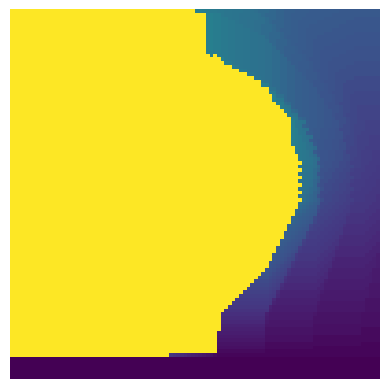

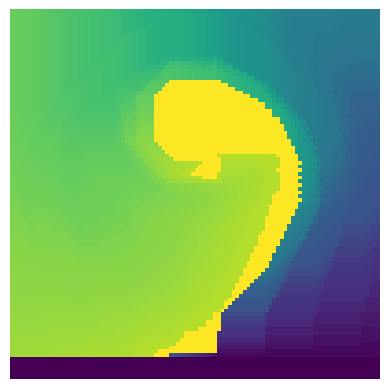

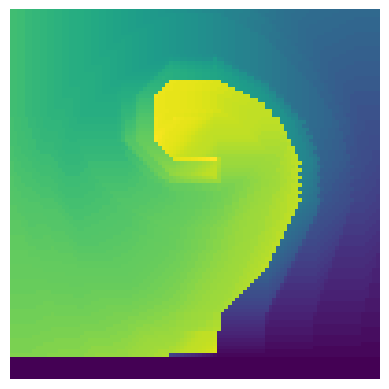

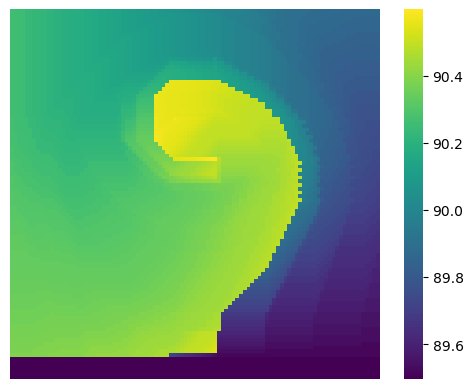

115


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


from utils.exact_value_function import get_exact_value, distance_to_optimal
from utils.partition_value import ValuePartition
from utils.calculus_projected import apply_pobo_until_var_small, projected_optimal_bellman_operator
from utils.calculus import norminf, get_value_policy_value, optimal_bellman_operator
from utils.partition_generic import GenericPartition
from utils.data_management import import_models_from_file
from utils.generic_model import GenericModel
import seaborn as sns

discount = 0.99
epsilon = 1e-2
Model = import_models_from_file('mountain')

s = 100
state = s**2

model:GenericModel = Model(state, 10)
model.create_model(False, False)
exact_value = get_exact_value(model, 'discounted', discount)

contracted_value = np.zeros((1))
partition = GenericPartition(model, discount)

partition._compute_weights_phi()
partition.compute_agg_trans_reward_v()

for i in range(3):
    for _ in range(8):

        for _ in range(10):
            contracted_value = projected_optimal_bellman_operator(model, discount, contracted_value, partition.aggregate_transition_matrix, partition.aggregate_reward_matrix, partition.weights)

        value = partition._partial_phi() @ contracted_value

        bellman_value = optimal_bellman_operator(model, value, discount)

        for _ in range(5):
            bellman_value = optimal_bellman_operator(model, bellman_value, discount)

        contracted_value = partition.divide_all_regions_along_value_update_contracted_value(bellman_value, 0.001, contracted_value)
        partition._compute_weights_phi()
        partition.compute_agg_trans_reward_v()

    value = -(partition._partial_phi() @ contracted_value).reshape((s, s))
    sns.heatmap(value, xticklabels=False, yticklabels=False, cbar=False, square=True, cmap=sns.color_palette("viridis", as_cmap=True))
    plt.savefig("mountain_abstraction_{}.png".format(i), dpi=400)
    plt.show()
    

value = -(partition._partial_phi() @ contracted_value).reshape((s, s))
sns.heatmap(value, xticklabels=False, yticklabels=False, square=True, cmap=sns.color_palette("viridis", as_cmap=True))
plt.savefig("mountain_abstraction_{}.png".format(i), dpi=400)
plt.show()

print(partition._number_of_regions())